### Spotify EDA
#### Clean Up DB

Database Cleanup Actions:
- Make new playlist table to store deleted entries

- iterate over all playlist items in batches of 50
- Check that artist link is valid
- If it returns something else - overwrite initial uri with the returned uri
- Check that artist is in artist table - if not load new artist - update popularity
- Check that track link is valid - if not valid, move to deleted entries table
- If valid, check that uri is in the track table - update popularity of track and artist


In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
import time
from time import sleep

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Table, Column, Integer, String, Float, MetaData, and_, or_
from sqlalchemy import create_engine
import sqlite3
from sqlalchemy.orm import sessionmaker
from sqlalchemy import exc

sys.path.append('../../')
from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator, pickle_load, pickle_save

%matplotlib inline

In [3]:
# !pip install ipywidgets 
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# %%capture
from tqdm import tqdm_notebook as tqdm



### Establish DataBase Connection

In [4]:
db_path = '../../data/SpotifyDataSet/spotify_songs.db'

# Get sesion
session = get_session(db_path)
engine = create_engine('sqlite:///' + db_path)

# Get Songs class
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")


In [5]:
# Create DB and Table if they don't exist


# connection = engine.connect() #creates db if it doesn't exist
# meta = MetaData()

# songs = Table(
#                 'songs', meta,
#                 Column('id', Integer, primary_key = True),
#                 Column('playlist_id', Integer),
#                 Column('pos', Integer), 
#                 Column('artist_name', String), 
#                 Column('track_uri', String),
#                 Column('artist_uri', String), 
#                 Column('track_name', String),
#                 Column('album_uri', String), 
#                 Column('duration_ms', String), 
#                 Column('album_name', String)
# )

# tracks = Table(
#                 'tracks', meta,
#                 Column('track_uri', String, primary_key = True),
#                 Column('artist_uri', String),
#                 Column('danceability', Float),
#                 Column('energy', Float),
#                 Column('key', Integer),
#                 Column('loudness', Float),
#                 Column('mode', Integer),
#                 Column('speechiness', Float),
#                 Column('acousticness', Float),
#                 Column('instrumentalness', Float),
#                 Column('liveness', Float),
#                 Column('valence', Float),
#                 Column('tempo', Float),
#                 Column('duration_ms', Integer),
#                 Column('time_signature', Integer)
# )

# artists = Table(
#                 'artists', meta,
#                 Column('artist_uri', String, primary_key = True),
#                 Column('followers', Integer),
#                 Column('genres', String),
#                 Column('artist_name', String),
#                 Column('artist_popularity', Integer)
# )

# meta.create_all(engine)

In [6]:
# session.rollback()
# session.commit()

### Establish Spotify API Connection

In [7]:
# Get URI for Artist, Track and Album for a song
rv = display_time(session.query(Playlists.track_name, 
                                Playlists.track_uri,
                                Playlists.artist_uri,
                                Playlists.album_uri).filter(Playlists.track_name=="Who Says").distinct().first)
rv.artist_uri
get_spotify_data(db_uri=rv.artist_uri, key='genres')

Time to Execute: 0.0 seconds
Setting credentials
token():INFO:   Getting initial token
token():INFO:   Token refreshed


['neo mellow', 'pop', 'pop rock', 'singer-songwriter']

In [8]:
# def build_track_string(uri_list:list) -> str:
#     rv_str = ''
    
#     for u in uri_list:
#         t_type, t_id = parse_spotify_url(u)
#         if t_type != "track":
#             print("ERR: Only 'track'-type uri's have features: {}".format(u))
#             return False
        
#         if rv_str == '':
#             rv_str += t_id
#         else:
#             rv_str += ',' + t_id
            
#     return rv_str

In [9]:
def load_tracks(uri_list, db_path, batch_size:int=100):
    """
    Loads a list of uris into the database.
    Returns a list of uris that were loaded
    If any item fails, no items from list are loaded.
    """
    
    engine = create_engine('sqlite:///' + db_path)
    Session = sessionmaker(bind = engine)
    session = Session()
    
    batch_gen = List_Generator.batch_generator(uri_list, batch_size=batch_size)

    loaded_uris = []
    for uri_batch in batch_gen:

        sp_tracks = get_audiofeatures(uri_batch)

        for t in sp_tracks:
            try:
                if t == None:
                    loaded_uris.append(None)

                else:
                    session.add(Tracks( track_uri           = t.get('uri'),
                                        artist_uri          = t.get('artists')[0].get('uri'),
                                        danceability        = t.get('danceability'),
                                        energy              = t.get('energy'),
                                        key                 = t.get('key'),
                                        loudness            = t.get('loudness'),
                                        mode                = t.get('mode'),
                                        speechiness         = t.get('speechiness'),
                                        acousticness        = t.get('acousticness'),
                                        instrumentalness    = t.get('instrumentalness'),
                                        liveness            = t.get('liveness'),
                                        valence             = t.get('valence'),
                                        tempo               = t.get('tempo'),
                                        duration_ms         = t.get('duration_ms'),
                                        time_signature      = t.get('time_signature')
                                      ) 
                               )
                    loaded_uris.append(t.get('uri'))

            except Exception as e:
                print(e)
                print("Problem happened at uri: {}".format(t))
                print("Graceful shutdown of session...")
                session.rollback()
                print("Closing session...")
                session.close()
                return [None]

    session.commit()
    session.close()
    return loaded_uris
    

In [10]:
def load_artists(artists_uri_list, db_path, batch_size:int=50):
    """
    Loads new artists into the Artits table.
    Can send a long list.  It will batch into batches of batch_size.
    Loads as many as it can before failing.
    """
    
    if type(artists_uri_list) != list:
        print("load_artsist() needs a list. '{}' type provided.".format(type(artists_uri_list)))
        return 0
    
    engine = create_engine('sqlite:///' + db_path)
    Session = sessionmaker(bind = engine)
    session = Session()
 
    loaded_uris = []
    
    batch_gen = List_Generator(artists_uri_list, batch_size=batch_size).batch_generator()
    
    for uri_batch in batch_gen:
    
        artists = get_artists(uri_batch)

        for a in artists:

            if a == None:
                loaded_uris.append(None)
                continue

            session.add(Artists( artist_uri          = a.get('uri'),
                                 followers           = a.get('followers').get('total'),
                                 genres              = ",".join(a.get('genres')),
                                 artist_name         = a.get('name'),
                                 artist_popularity   = a.get('popularity')
                               )
                       )

        try:
            session.commit()
            loaded_uris.append(a.get('uri'))
            
        except Exception as e:
            print(e)
            session.rollback()

            # commit individually
            for i, a in enumerate(artists):
                session.add(Artists( artist_uri          = a.get('uri'),
                                     followers           = a.get('followers').get('total'),
                                     genres              = ",".join(a.get('genres')),
                                     artist_name         = a.get('name'),
                                     artist_popularity   = a.get('popularity')
                                   )
                           )
                try:
                    session.commit()
                    loaded_uris.append(a.get('uri'))
                    
                except Exception as e:
                    print("Artist Load ERR:{}   {} - {}".format(i, a.get('uri'), a.get('name') ))
                    session.rollback()

    session.close()
    return loaded_uris

### DB Cleanup

Database Cleanup Actions:
- Make new playlist table to store deleted entries

- iterate over all playlist items in batches of 50
- Check that artist link is valid
- If it returns something else - overwrite initial uri with the returned uri
- Check that artist is in artist table - if not load new artist - update popularity
- Check that track link is valid - if not valid, move to deleted entries table
- If valid, check that uri is in the track table - update popularity of track and artist

In [11]:
# Check that artists exist in Artist table - load, if they don't
# returns the artist db entries
def get_db_artists(artist_uri_list, load_missing:bool=False, debugging:bool=False) -> list:
    """
    Checks that a list of artists exists in the Artists
    table and will load any that don't exist if load_missing=True.
    Returns list of db records for artists.  
    If not found, None entry is included in list.
    """
    session = get_session(db_path)
    
    db_artist_list = []
    try:
        for a in artist_uri_list:
            db_artist = session.query(Artists).filter(Artists.artist_uri==a).first()
            if db_artist == None: # if not in table
                if load_missing:
                    if debugging:
                        print("Loading missing artist: {}".format(a))
                    loaded_uris = load_artists([a], db_path)
                    if loaded_uris[0] == None:
                        db_artist_list.append(None)
                    else:
                        # now get the db isting of the artist
                        db_artist = session.query(Artists).filter(Artists.artist_uri==a).first()
                        db_artist_list.append(db_artist)
                else:
                    db_artist_list.append(None)
    except Exception as e:
        print("get_db_artists(): ERR at laoding uri: {}".format(a))
        print(e)
        
    
    session.close()
    
    if debugging:
        none_idxs = np.where(np.array(db_artist_list))
        if len(none_idxs)>0:
            print("Note uris that are not in DB. Returned as 'None' is list:")
            for i in none_idxs:
                print("\t{}".format(artist_uri_list[i]))
    
    return db_artist_list

In [12]:
# Check that artists exist in Artist table - load, if they don't
# returns the artist db entries
def get_db_tracks(track_uri_list, load_missing:bool=False, debugging:bool=False) -> list:
    """
    Checks that a list of tracks exists in the Tracks
    table and will load any that don't exist if load_missing=True.
    Returns list of db records for tracks.  
    If not found, None entry is included in list.
    """
    session = get_session(db_path)
    
    db_track_list = []
    try:
        for t in track_uri_list:
            db_track = session.query(Tracks).filter(Tracks.track_uri==t).first()
            if db_track == None:
                if load_missing:
                    if debugging:
                        print("Loading missing track: {}".format(t))
                    loaded_uris = load_tracks([t], db_path)
                    if loaded_uris[0] == None:
                        db_track_list.append(None)
                    else:
                        # now get the db listing of the track
                        db_track = session.query(Tracks).filter(Tracks.track_uri==t).first()
                        db_track_list.append(db_track)
                else:
                    db_track_list.append(None)
    except Exception as e:
        print("get_db_tracks() ERR at loading uri: {}".format(t))
        print(e)
    
    session.close()
    
    if debugging:
        none_idxs = np.where(np.array(db_track_list))
        if len(none_idxs)>0:
            print("Note uris that are not in DB. Returned as 'None' is list:")
            for i in none_idxs:
                print("\t{}".format(track_uri_list[i]))
        
    return db_track_list

In [13]:
def update_artist_table(artist_uris:list=None, batch_size:int=50):
    """
    Updates the artist followers, popularity and genres in the Artist table.
    If 'artist_uris' argument is blank, updates all.
    If list is provided, updates only the items in the list and adds them if missing.
    """
    main_session = get_session(db_path)
    batch_gen = ''
    if artist_uris != None:
        db_artists = get_db_artists(artist_uris, load_missing=True) # creates entries if missing
        if len(db_artists) == 0:
            print("No matching URIs in DB.  No artists updated.")
            return
        batch_gen = List_Generator(db_artists, batch_size=batch_size).batch_generator()
    else:
        query = main_session.query(Artists)
        batch_gen = Table_Generator(query=query, batch_size=batch_size).batch_generator()
    
    try:
        for db_artists in batch_gen:

            # get spotify artists
            db_artist_uris = [a.artist_uri for a in db_artists]
            sp_artists = get_artists(db_artist_uris)
            if sp_artists == False:
                raise Exception("Unable to get data from Spotify.  Service may be down.")

            # update each artist with spotify data
            for db_artist, sp_artist in zip(db_artists, sp_artists):
                db_artist.followers = sp_artist.get("followers").get("total")
                db_artist.artist_popularity = sp_artist.get("popularity")
                db_artist.genres = ",".join(sp_artist.get('genres'))

    except Exception as e:
        print(e)
        print("Graceful session termination...")
        main_session.rollback()
        main_session.close()
        return None
    
    print("Committing Session ...")
    main_session.commit()
    print("Closing Session ...")
    main_session.close()
    

In [16]:
# Takes about 15 minutes
# Iterates over every artist and will update popularity and followers
update_artist_table()

Creating Table Generator:
	batch size :  50
	length     :  296014
	num batches:  5921



Committing Session ...
Closing Session ...


In [14]:
def update_tracks_table(track_uris:list=None, batch_size:int=50):
    """
    Updates the tracks table popularity and artist URI.
    Returns a list of tracks that are not available in Spotify.
    If argument is blank, updates all table records.
    If argument is provided, updates only the items in the list and adds them if missing.
    """
    main_session = get_session(db_path)
    batch_gen = ''
    artists_not_in_spotify = []
    if track_uris != None:
        #make generator from a list
        db_tracks = get_db_tracks(track_uris) # creates entries if missing
        if len(db_tracks) == 0:
            print("No matching URIs in DB.  No tracks updated.")
            return
        
        batch_gen = List_Generator(db_tracks, batch_size=batch_size).batch_generator()
    else:
        # make generator from database
        query = main_session.query(Tracks).filter(Tracks.track_popularity==None)
        batch_gen = Table_Generator(query=query, batch_size=batch_size).batch_generator()
    
    for db_tracks in batch_gen:

        # get spotify tracks
        db_track_uris = [t.track_uri for t in db_tracks]
        sp_tracks = get_tracks(db_track_uris)
        if sp_tracks == False:
            continue
        
        # see if spotify returns some as None - remove them from the update lists
        none_idxs = np.where(np.array(sp_tracks)==None)[0]
        
        try:
            if len(none_idxs) > 0:
                none_idxs[::-1].sort() # sort them descending to pop off the end first
                for i in none_idxs:
                    db_tracks.pop(i)
                    sp_tracks.pop(i)
                    artists_not_in_spotify.append(db_track_uris.pop(i))

            if len(db_tracks)!= len(sp_tracks):
                print("List length error.  db_tracks:{} sp_tracks:{}".format(db_tracks, sp_tracks))
                main_session.rollback()
                main_session.close()
                return
        except Exception as e:
            print(e)
            print("Closing.  Check rv for values on error.")
            main_session.close()
            return [db_tracks, sp_tracks, db_track_uris, artists_not_in_spotify]
            
        
        # update each track with spotify data
        for db_track, sp_track in zip(db_tracks, sp_tracks):
            if db_track==None or sp_track==None:
                continue
            db_track.track_popularity = sp_track.get("popularity")
            db_track.artist_uri = sp_track.get("artists")[0].get("uri")
    
            main_session.commit()
        
    main_session.close()
    
    return artists_not_in_spotify

In [15]:
# takes 2hrs to to populate entire list
# Iterates over all tracks in Playlists table and will update the popularlity and artist uri
# Returns a list of tracks that are not in Spotify database
missing_tracks_in_spotify = update_tracks_table()

Creating Table Generator:
	batch size :  50
	length     :  584
	num batches:  12


In [18]:
print ("Number of Missing Tracks: {}".format(len(missing_tracks_in_spotify)))

Number of Missing Tracks: 584


In [20]:
# save pickle file of missing track uris
pickle_save(missing_tracks_in_spotify, 'missing_tracks_in_spotify.pkl')

In [21]:
def delete_tracks(track_uris:list, table_name, batch_size:int=200) -> list:
    """
    Deletes tracks from the table_name provided
    """
    # if num tracks is < batch_size, make batch_size same as num track_uris
    if len(track_uris) < batch_size:
        batch_size = len(track_uris)
    
    # Setup generators
    session = get_session(db_path)
    batch_list_gen = List_Generator(track_uris, batch_size=batch_size).batch_generator()
    
    for batch_track_uris in batch_list_gen:
        db_records = session.query(table_name).filter(table_name.track_uri.in_(batch_track_uris)).delete()
        session.commit()
    
    session.close()
    
    

In [22]:
def clean_up_db(delete:bool=False, batch_size:int=50):
    """
    Check to make sure that the artist uri is current.
    Make sure entries have valid track and artist uris.
    Removes items where uri is not valid.
    """
    main_session = get_session(db_path)
    query = main_session.query(Playlists)
    batch_gen = Table_Generator(query=query, batch_size=batch_size).batch_generator()

    playlist_ids_to_delete = []
    artists_to_update = []
    
    try:
        for batch in batch_gen:

            # build a list of track uris, artist uris
            uris = [(r.track_uri, r.artist_uri) for r in batch]
            uris = np.array(uris)
            db_track_uris = uris[:,0]
            db_artist_uris = uris[:,1]


            # TRACKS - adds if they dont exists - includes None's where invalid
            db_tracks = np.array(get_db_tracks(db_track_uris.tolist()))

            # ARTISTS - adds if they dont exists - includes None's where invalid
            db_artists = np.array(get_db_artists(db_artist_uris.tolist(), load_missing=True))

            # Check if any tracks/artists are None - remove them from db and lists we made
            for db_cat in (db_tracks, db_artists):
                none_idxs = np.where(db_cat==None)[0]
                if len(none_idxs)>0:
                    # remove from db, batch, sp_tracks and sp_artists
                    for idx in none_idxs:
                        if delete:
                            main_session.delete(batch[idx])
                        playlist_ids_to_delete.append(batch[idx].get('id'))
                        batch.pop(idx)
                        db_tracks.pop(idx)
                        db_artists.pop(idx)

                    # remove from db_track_uris, db_artist_uris, 
                    db_track_uris  = np.delete(db_track_uris, none_idxs)
                    db_artist_uris = np.delete(db_artist_uris, none_idxs)


            # make sure we don't have any list mis-matches
            if len(db_artist_uris) != len(batch):
                raise Exception("clean_up_db() ERR: list length error: db_artists={}  batch={}".format(len(db_artist_uris), len(batch))) 

            # iterate over remaining records in batch
            # update artist if changed - spotify changes artist uris sometimes
            for r, record in enumerate(batch):
                # check if artist uri has been updated - if so update in playlists table
                db_playlist_artist_uri = record.artist_uri
                db_artist_uri = db_artist_uris[r]

                if  db_playlist_artist_uri != db_artist_uri:
                    print("Need to update artist from: {}  to: {}".format(db_playlist_artist_uri, db_artist_uri))
                    artists_to_update.append((db_playlist_artist_uri, db_artist_uri))
                    if delete:
                        record.artist_uri = db_artist_uri
    except Exception as e:
        print(e)
        print("Graceful rollback ...")
        main_session.rollback()
        print("Session close ...")
        main_session.close()
        return artists_to_update, playlist_ids_to_delete

    print("Session commit ...")
    main_session.commit()
    print("Session close ...")
    main_session.close()
    
    return artists_to_update, playlist_ids_to_delete
    

In [23]:
# takes days to execute
# artists_to_update, playlist_ids_to_delete = clean_up_db()

### Missing Tracks Review and Updates

In [24]:
eric_missing_tracks = pickle_load('eric_bad_track_uris.pkl')

In [25]:
mark_missing_tracks = pickle_load('missing_tracks_in_spotify.pkl')

In [26]:
len(eric_missing_tracks), len(mark_missing_tracks)

(584, 584)

In [27]:
in_both_lists = list(set(eric_missing_tracks) & set(mark_missing_tracks))

In [28]:
len(in_both_lists)

584

In [29]:
in_eric_not_in_mark = set(eric_missing_tracks) - set(mark_missing_tracks)
in_mark_not_in_eric = set(mark_missing_tracks) - set(eric_missing_tracks)


In [30]:
len(in_eric_not_in_mark), len(in_mark_not_in_eric)

(0, 0)

### Check a Missing Tracks List
Make sure that all of the missing tracks return None from Spotify

In [31]:
def check_tracks_for_none(track_uris:list) -> np.array:
    """
    Checks that a list of artists returns None.
    Returns list of valid artist urls that were in the list.
    """
    batch_gen = List_Generator(track_uris, batch_size=50).batch_generator()

    orig_tracks = []
    sp_tracks = []
    for batch in batch_gen:
        batch_sp_tracks = get_tracks(batch)
        for t in batch_sp_tracks:
            if t==None:
                sp_tracks.extend(["None"])
            else:
                sp_tracks.extend([t.get('uri')])

        orig_tracks.extend(batch)

    idxs = np.where(np.array(sp_tracks)!="None")

    if len(idxs[0])>0:
        print("The following tracks were in list but returned sportify values:")
        for i in idxs[0]:
            print("list: {}  spotify: {}".format(orig_tracks[i], sp_tracks[i]))
        return np.array(sp_tracks)[idxs]
    else:
        print("All provided tracks returned 'None' from Spotify!")
    
    return None

In [32]:
sp_tracks = check_tracks_for_none(eric_missing_tracks)

Creating List Generator:
	batch size :  50
	length     :  584
	num batches:  12



All provided tracks returned 'None' from Spotify!


### Remove the Missing Tracks from Table
specifiy Tracks or Playlists in the TABLE argument

In [33]:
def remove_none_tracks(track_uris:np.array, TABLE, batch_size:int=50) -> list:
    """
    Removes a list of uris from the Tracks and Playlists tables.
    First checks that items truly return None from Spotify before deleting.
    """
    
    print("Preparing to delete records from table: \n{}".format(TABLE))
    
    # First check that they are all "None" in Spotify
    sp_results = check_tracks_for_none(track_uris)
    if sp_results != None:
        print("Some URIS were valid in Spotify.  No deletions made.")
        return sp_results
    
    removed_uris = []
    
    # get Table entries
    print("Getting records to delete from database...")
    main_session = get_session(db_path)
    query = main_session.query(TABLE).filter(TABLE.track_uri.in_(track_uris))
    batch_gen = Table_Generator(query=query, batch_size=batch_size, name="deleting tracks progress").batch_generator()
    
    # iterate batches and delete entries
    del_count = 0
    try:
        print("Deleting records ...")
        for batch in batch_gen:
            for item in batch:
                main_session.delete(item)
                main_session.commit()
                del_count += 1
            main_session.commit()
        
    except Exception as e:
        print (e)
        print ("ERR: Exception ocurred.  Rolling back.  No deletes made.")
        print ("ERR: Error ocurred when handling: {}",item.track_uri)
        main_session.rollback()
        main_session.close()
        return
    
    main_session.commit()
    print("Done.  Deleted {} records.".format(del_count))
    main_session.close()
    return 

In [34]:
missing_tracks = pickle_load('eric_bad_track_uris.pkl')

In [44]:
# Remove tracks from Playlists table
remove_none_tracks(missing_tracks, Playlists) # completed on 11/7/2019 - takes 3hrs

Preparing to delete records from table: 
<class 'spotify_database.get_session.<locals>.Playlists'>
Creating List Generator:
	batch size :  50
	length     :  584
	num batches:  12


token():INFO:   Token refreshed

All provided tracks returned 'None' from Spotify!
Getting records to delete from database...
Creating Table Generator:
	batch size :  50
	length     :  50
	num batches:  2
Deleting records ...



Done.  Deleted 50 records.


In [42]:
# Remove tracks from Tracks table
remove_none_tracks(missing_tracks, Tracks) # completed on 11/7/2019

Preparing to delete records from table: 
<class 'spotify_database.get_session.<locals>.Tracks'>
Creating List Generator:
	batch size :  50
	length     :  584
	num batches:  12



All provided tracks returned 'None' from Spotify!
Getting records to delete from database...
Creating Table Generator:
	batch size :  50
	length     :  50
	num batches:  2
Deleting records ...



Done.  Deleted 50 records.


### Update mis-matched Artist Records
Some records in the db return an updated artist uri from Spotify.
These are updated in the Playlists and Artists Table

In [45]:
def check_mismatched_artists(artist_uris:dict):
    """
    Checks that dict of artist returns a new value from Spotify.
    Argument is in form {db_uri:spotify_uri}
    Returns a list of the incorrect entries.  If list has zero length, all are correct.
    """
    print("Validating mis-mathced entries...")
    # convert to numpy array [:,0] is db uris and [:,1] is new spotify uris
    np_artists = np.array([(k,v) for (k,v) in mismatched_artists.items()])
    db_artists, sp_artists = np_artists[:,0], np_artists[:,1]
    
    db_batch_gen = List_Generator(list(db_artists), batch_size=50).batch_generator()
    sp_batch_gen = List_Generator(list(sp_artists), batch_size=50).batch_generator()
    
    sp_uris = []
    for db_artist_batch, sp_artist_batch in zip(db_batch_gen, sp_batch_gen):
        sp_artists = get_artists(db_artist_batch)
        sp_artists_uris = [a.get("uri") for a in sp_artists]
        sp_uris.extend(sp_artists_uris)
        
        # compare sp_artist_batch and sp_artists -- they should be the same
        mismatch_idxs = np.where(sp_artist_batch!=sp_artists_uris)
        
        if len(mismatch_idxs[0])>0:
            for idx in mismatch_idxs[0]:
                print("ERR: for db track: {}".format(db_artist_batch[idx]))
                print("\t List said: {}  spotify says: {}",format(sp_artist_batch[idx], sp_artists_uris[idx]))
    
    incorrect_entries = np_artists[np.where(np.array(sp_uris)!=np_artists[:,1])]
    if len(incorrect_entries)==0:
        print("All mis-matched entries have been validated!")

    return incorrect_entries
    
    

In [46]:
def update_mismatched_artists(mismatched_artists:dict, TABLE):
    """
    Updates artist uri records in a table.
    First checks that supplied table is correct.
    Nothing returned.  Confirmation message sent to output.
    """
    
    incorrect_entries = check_mismatched_artists(mismatched_artists)
    if len(incorrect_entries)>0:
        print("There are incorrectly identified mismatches in the list.")
        print("No updates were made.  Correct list and retry.")
        return incorrect_entries
    
    # convert to numpy array [:,0] is db uris and [:,1] is new spotify uris
    np_artists = np.array([(k,v) for (k,v) in mismatched_artists.items()])
    db_artists, sp_artists = np_artists[:,0], np_artists[:,1]
    
    # get Table entries
    print("Getting records to update from database...")
    main_session = get_session(db_path)
    query = main_session.query(TABLE).filter(TABLE.artist_uri.in_(list(db_artists)))
    batch_gen = Table_Generator(query=query, batch_size=50).batch_generator()
    
    update_count = 0
    old_uri = ''
    try:
        print("Updating records ...")
        for batch in batch_gen:
            for item in batch:
                new_uri = mismatched_artists.get(item.artist_uri)
                if new_uri != None:
                    old_uri = item.artist_uri
                    item.artist_uri = new_uri
                    try:
                        main_session.commit()
                    except exc.IntegrityError as e:
                        print("Entry already exists: {}  Deleting old record: {}".format(new_uri, old_uri))
                        main_session.rollback()
                        main_session.delete(item)
                        main_session.commit()
                        update_count += 1
    
    
    except Exception as e:
        print (e)
        print ("ERR: Exception ocurred.  Rolling back.  No deletes made.")
        print ("ERR: Error ocurred when handling: {}".format(old_uri))
        main_session.rollback()
        main_session.close()
        return
    
    print("Updates complete!  {} records updated.".format(update_count))
    return
    
    

In [47]:
mismatched_artists = pickle_load('eric_mismatched_artist_uris.pkl')

In [ ]:
# Update mismatched artists in the Playlists table
update_mismatched_artists(mismatched_artists, TABLE=Playlists) # updated 11/7

Validating mis-mathced entries...
Creating List Generator:
	batch size :  50
	length     :  17
	num batches:  1
Creating List Generator:
	batch size :  50
	length     :  17
	num batches:  1


All mis-matched entries have been validated!
Getting records to update from database...


In [49]:
# Update mismatched artists in the Artists table
# update_mismatched_artists(mismatched_artists, TABLE=Artists) # updated 11/7

Validating mis-mathced entries...
Creating List Generator:
	batch size :  50
	length     :  17
	num batches:  1
Creating List Generator:
	batch size :  50
	length     :  17
	num batches:  1


All mis-matched entries have been validated!
Getting records to update from database...
Creating Table Generator:
	batch size :  50
	length     :  17
	num batches:  1
Updating records ...


Entry already exists: spotify:artist:2URUumnB8mguimUYWej7Vh  Deleting old record: spotify:artist:0cVSr2fyCKZhweKdgDtzpv
Entry already exists: spotify:artist:5JZYv0z6YzsztblsEpst8g  Deleting old record: spotify:artist:2X559F6FePOMHWNjY926ja
Entry already exists: spotify:artist:1XujSdsxykPhP3dn6HaT4l  Deleting old record: spotify:artist:2t4d35GMIVX8cQFYbP89j8
Entry already exists: spotify:artist:6ISSzeT1ACKbGLO0JBZ23r  Deleting old record: spotify:artist:3S4Y2OLp04uG7EgeLUuP5v
Entry already exists: spotify:artist:6fTEkjuuZ3hH6fdeBxxbA2  Deleting old record: spotify:artist:3ts3Txswf4tjfQIY2nC43m
Entry already exists: spotify:artist:6GqL4bwmVbFVhvupr8HF4u  Deleting old record: spotify:artist:40dWpjd3A0HVYI2Y7ReobD
Entry already exists: spotify:artist:1vc9BdsxN00MpgIY1lifuB  Deleting old record: spotify:artist:4WIIabZbvghOasFdVWyl68
Entry already exists: spotify:artist:39KwCUfxTyIasDijrgwhRn  Deleting old record: spotify:artist:4k2mSg1rvHksEIWk0d876L
Entry already exists: spotify:artist:2Uo

In [ ]:
# Update mismatched artists in the Tracks table
update_mismatched_artists(mismatched_artists, TABLE=Tracks) # updated 11/7

### Check Database for completeness in Tracks Table
1) check for any values with blanks <br>
2)

In [10]:
all_tracks = session.query(Tracks).all()

In [11]:
# for record in example_record:
#     for k,v in record.__dict__.items():
#         print("{:30} : {}".format(k,v))
#     print('')

In [12]:

df_all_tracks = pd.DataFrame([x.__dict__ for x in all_tracks]).drop('_sa_instance_state', axis=1).set_index(['track_uri', 'artist_uri'])

In [13]:
df_all_tracks.head()

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,
spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,11,0.467,4,108.130,0.2770,0.000001,0.0336,-9.649,0.157,65,242564,0.0816,0.974,1
spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,10,0.312,4,93.778,0.2780,0.008180,0.0347,-13.367,0.207,36,253933,0.0773,0.961,1
spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,9,0.412,4,85.462,0.0389,0.772000,0.0278,-14.214,0.159,54,103920,0.0830,0.991,1
spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,9,0.264,4,148.658,0.0735,0.349000,0.0349,-15.399,0.122,72,371320,0.0940,0.885,1
spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,8,0.658,4,128.128,0.1910,0.000000,0.0448,-10.866,0.179,75,238560,0.1700,0.689,1


## Fix NaN Values

In [14]:
df_all_tracks[df_all_tracks.isnull().any(axis=1)]

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,


In [14]:
# One track with a Nan value


Text(0.5, 1.0, "Distribtion of Tracks Feature: 'valence''")

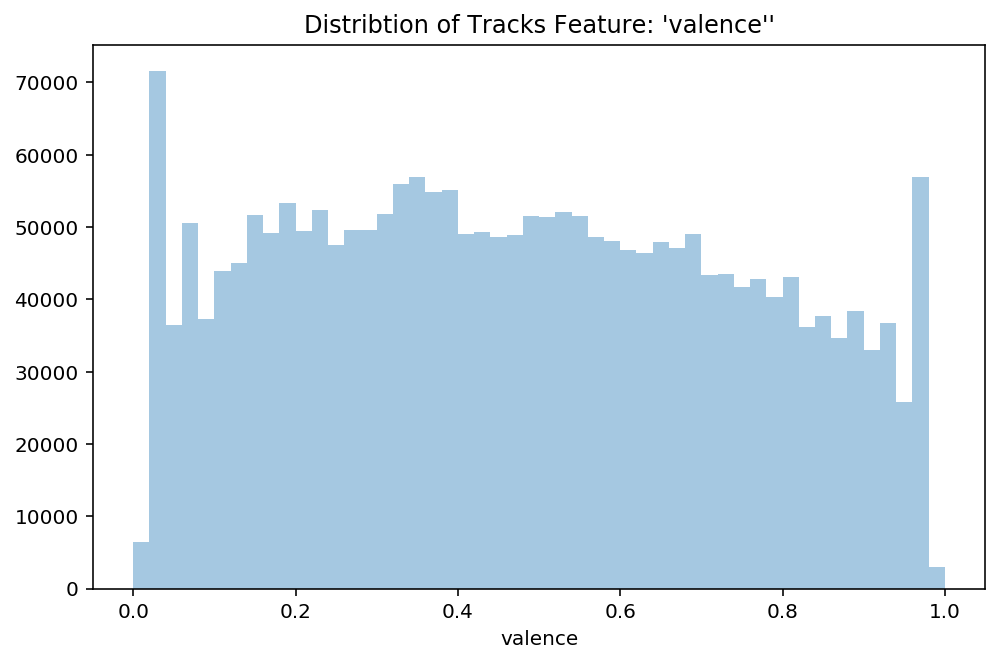

In [34]:
features = df_all_tracks.columns

i=4
df_valence = df_all_tracks[~df_all_tracks[features[i]].isnull()][features[i]]

fig, subplot  = plt.subplots(figsize=(8,5))

ax = subplot
sns.distplot(df_valence, kde=False, ax=ax)
ax.set_title("Distribtion of Tracks Feature: '{}''".format(features[i]))

## **valence**
Values look reasonably distributed.  We have one record that has a NaN value.  Based on the distribution, we an safely put the median of the dataset's valence value in place of the Nan.  Other than that, there are 3130 records with a zero value for valence.

In [37]:
# Update Nan value with median
valence_median = np.median(df_valence) # 0.466
valence_median

0.466

In [42]:
# df record of Nan entry
df_valence_nan = df_all_tracks[df_all_tracks.isnull().any(axis=1)]
valence_nan_track_uri = df_valence_nan.index[0]
valence_nan_track_uri

'spotify:track:27AyeOoNoGue7zRyH4CR1I'

In [54]:
# get the db record and set value - commit session to save change
db_valence_nan = [x for x in all_tracks if x.track_uri==valence_nan_track_uri]
db_valence_nan[0].valence = valence_median
session.commit()

In [60]:
df_all_tracks[df_all_tracks.valence==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.000,0,0.000,0.0,0.000,0.000,-26.632,0.000000,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0000,0.0000,1
spotify:track:7CI5MmJtCRjuctwiHgLn2s,5,0.522,3,94.245,0.0,0.967,0.116,-14.277,0.172000,spotify:artist:016orrDdwwKtetwh5yHPgD,0,32288,0.1150,0.9930,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,0,0.000,0,0.000,0.0,0.000,0.000,-60.000,0.000000,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,35000,0.0000,0.0000,0
spotify:track:5Grs7a94NsSwMiog9ZmE6l,8,0.000,0,0.000,0.0,0.710,0.000,-26.203,0.000248,spotify:artist:4OGJOCR3m1HC87JGx8cuEQ,0,311705,0.1130,0.1260,1
spotify:track:0uXpadbqwbLO0PQtqO7J8Q,10,0.000,0,0.000,0.0,0.956,0.000,-12.110,0.605000,spotify:artist:1zrMGaRSRvx67vF4xzvUcu,0,8293,0.2850,0.2600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:0kLSsmrec6U3Pe9ml4mzOX,3,0.000,0,0.000,0.0,0.000,0.000,-26.347,0.248000,spotify:artist:35fFUv2850L9CQjjNrLBpb,0,10280,0.2800,0.3940,1
spotify:track:5l3pialxu9lFIAIjITWx9z,2,0.000,0,0.000,0.0,0.995,0.000,-16.481,0.230000,spotify:artist:5zyNXVd952fWOjkdGHCvPd,0,14547,0.3260,0.9850,1
spotify:track:4wnc62W4oPPOP5PVxU63pR,4,0.000,0,0.000,0.0,0.000,0.000,-11.122,0.175000,spotify:artist:2XHTklRsNMOOQT56Zm3WS4,0,10253,0.0943,0.8250,1


## Review All Features

In [15]:
df_all_tracks.describe()

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
count,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261596e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06
mean,5.261050e+00,5.504661e-01,3.879982e+00,1.199810e+02,4.757893e-01,2.207979e-01,8.935614e-02,-9.659046e+00,5.849420e-01,1.267791e+01,2.474320e+05,2.092522e-01,3.548610e-01,6.550491e-01
std,3.558882e+00,1.845284e-01,4.717985e-01,2.992131e+01,2.699184e-01,3.493907e-01,1.152923e-01,5.623792e+00,2.659486e-01,1.391448e+01,1.560575e+05,1.899007e-01,3.543532e-01,4.753524e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,4.270000e-01,4.000000e+00,9.693200e+01,2.470000e-01,0.000000e+00,3.540000e-02,-1.190900e+01,3.890000e-01,0.000000e+00,1.842930e+05,9.580000e-02,2.230000e-02,0.000000e+00
50%,5.000000e+00,5.650000e-01,4.000000e+00,1.200060e+02,4.660000e-01,6.020000e-04,4.710000e-02,-8.176000e+00,6.220000e-01,8.000000e+00,2.252930e+05,1.280000e-01,2.150000e-01,1.000000e+00
75%,8.000000e+00,6.890000e-01,4.000000e+00,1.380510e+02,6.970000e-01,4.210000e-01,8.400000e-02,-5.825000e+00,8.090000e-01,2.100000e+01,2.783070e+05,2.640000e-01,6.910000e-01,1.000000e+00
max,1.100000e+01,9.960000e-01,5.000000e+00,2.499870e+02,1.000000e+00,1.000000e+00,9.710000e-01,4.923000e+00,1.000000e+00,8.800000e+01,6.047705e+06,1.000000e+00,9.960000e-01,1.000000e+00


In [ ]:
# key OK - range of 0 to 11
# danceability OK - range of 0 to 1
# time_signature ??? - range of 0 to 5 <<< check the time signatures of 0
# tempo - range of 0 to 250 <<< check items with 0 tempo
# valence - range of 0 to 1 <<< check 0's
# instrumentatness - OK - range of 0 to 1
# speechiness - OK - range of 0 to 1
# loudness - range -60 to 5 <<< positive values may be incorrect
# energy - range 0 to 1
# track popularity - range 0 to 88 <<< may have top end outliers <<< 0's might be issue
# duration - range 1000 to 6047705 <<< end may be an issue << 1 sec and 6047 seconds
# liveness - range 0 to 1
# accousticness - range 0 to 1
# mode - range 0 to 1 - looks binary - what is this?


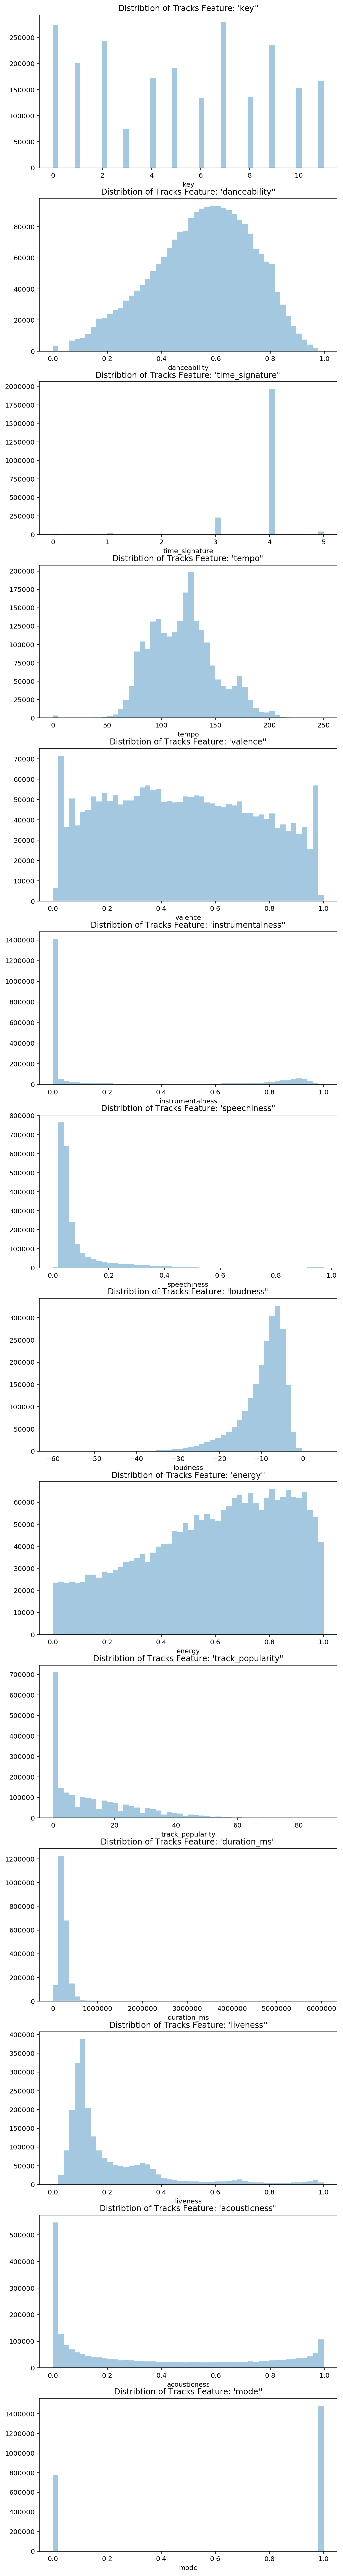

In [16]:
features = df_all_tracks.columns
fig, subplot  = plt.subplots(nrows=len(features), figsize=(8,len(features)*5))
# fig.tight_layout()

for i, ax in enumerate(np.ravel(subplot)):
    sns.distplot(df_all_tracks[features[i]], kde=False, ax=ax)
    ax.set_title("Distribtion of Tracks Feature: '{}''".format(features[i]))

## **key**
Values look reasonably distributed.  We have no mapping from the numerical value to the musical key, but this should not matter in our model.

## **danceability**
Values look reasonably distributed.  We don't know how the numerical value translates, , but this should not matter in our model.  There are a few zeros points.  For these points (3133) most song accoustic features are zero.  These are unavailable in Spotify.  Not sure how to treat these yet.

In [20]:
df_all_tracks[df_all_tracks.danceability==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.0,0,0.0,0.0,0.000,0.0,-26.632,0.000000,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0000,0.000,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,0,0.0,0,0.0,0.0,0.000,0.0,-60.000,0.000000,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,35000,0.0000,0.000,0
spotify:track:5Grs7a94NsSwMiog9ZmE6l,8,0.0,0,0.0,0.0,0.710,0.0,-26.203,0.000248,spotify:artist:4OGJOCR3m1HC87JGx8cuEQ,0,311705,0.1130,0.126,1
spotify:track:0uXpadbqwbLO0PQtqO7J8Q,10,0.0,0,0.0,0.0,0.956,0.0,-12.110,0.605000,spotify:artist:1zrMGaRSRvx67vF4xzvUcu,0,8293,0.2850,0.260,0
spotify:track:1N9fTHrfg7izPShUxBuzTc,0,0.0,0,0.0,0.0,0.000,0.0,-13.332,0.336000,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,0,10000,0.1430,0.566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:2m6AnC9CvHcYa7EbjzJk22,0,0.0,0,0.0,0.0,0.000,0.0,-12.457,0.361000,spotify:artist:4z5JitgPAYeLR4fYLIHf4i,0,6000,0.0000,0.951,1
spotify:track:0kLSsmrec6U3Pe9ml4mzOX,3,0.0,0,0.0,0.0,0.000,0.0,-26.347,0.248000,spotify:artist:35fFUv2850L9CQjjNrLBpb,0,10280,0.2800,0.394,1
spotify:track:5l3pialxu9lFIAIjITWx9z,2,0.0,0,0.0,0.0,0.995,0.0,-16.481,0.230000,spotify:artist:5zyNXVd952fWOjkdGHCvPd,0,14547,0.3260,0.985,1


## **time_signature**
Most values are 4 (presumably 4/4, which is very common).  Looks at 0 values below.  We find 3180 that have a zero value.  These entries seems to have many other values that are zero.

In [22]:
df_all_tracks[df_all_tracks.time_signature==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.0,0,0.0,0.0,0.000,0.0,-26.632,0.000000,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0000,0.000,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,0,0.0,0,0.0,0.0,0.000,0.0,-60.000,0.000000,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,35000,0.0000,0.000,0
spotify:track:5Grs7a94NsSwMiog9ZmE6l,8,0.0,0,0.0,0.0,0.710,0.0,-26.203,0.000248,spotify:artist:4OGJOCR3m1HC87JGx8cuEQ,0,311705,0.1130,0.126,1
spotify:track:0uXpadbqwbLO0PQtqO7J8Q,10,0.0,0,0.0,0.0,0.956,0.0,-12.110,0.605000,spotify:artist:1zrMGaRSRvx67vF4xzvUcu,0,8293,0.2850,0.260,0
spotify:track:1N9fTHrfg7izPShUxBuzTc,0,0.0,0,0.0,0.0,0.000,0.0,-13.332,0.336000,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,0,10000,0.1430,0.566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:2m6AnC9CvHcYa7EbjzJk22,0,0.0,0,0.0,0.0,0.000,0.0,-12.457,0.361000,spotify:artist:4z5JitgPAYeLR4fYLIHf4i,0,6000,0.0000,0.951,1
spotify:track:0kLSsmrec6U3Pe9ml4mzOX,3,0.0,0,0.0,0.0,0.000,0.0,-26.347,0.248000,spotify:artist:35fFUv2850L9CQjjNrLBpb,0,10280,0.2800,0.394,1
spotify:track:5l3pialxu9lFIAIjITWx9z,2,0.0,0,0.0,0.0,0.995,0.0,-16.481,0.230000,spotify:artist:5zyNXVd952fWOjkdGHCvPd,0,14547,0.3260,0.985,1


## **tempo**
Values look reasonably distributed.  3130 entries have a value of 0.

In [24]:
df_all_tracks[df_all_tracks.tempo==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.0,0,0.0,0.0,0.000,0.0,-26.632,0.000000,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0000,0.000,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,0,0.0,0,0.0,0.0,0.000,0.0,-60.000,0.000000,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,35000,0.0000,0.000,0
spotify:track:5Grs7a94NsSwMiog9ZmE6l,8,0.0,0,0.0,0.0,0.710,0.0,-26.203,0.000248,spotify:artist:4OGJOCR3m1HC87JGx8cuEQ,0,311705,0.1130,0.126,1
spotify:track:0uXpadbqwbLO0PQtqO7J8Q,10,0.0,0,0.0,0.0,0.956,0.0,-12.110,0.605000,spotify:artist:1zrMGaRSRvx67vF4xzvUcu,0,8293,0.2850,0.260,0
spotify:track:1N9fTHrfg7izPShUxBuzTc,0,0.0,0,0.0,0.0,0.000,0.0,-13.332,0.336000,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,0,10000,0.1430,0.566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:2m6AnC9CvHcYa7EbjzJk22,0,0.0,0,0.0,0.0,0.000,0.0,-12.457,0.361000,spotify:artist:4z5JitgPAYeLR4fYLIHf4i,0,6000,0.0000,0.951,1
spotify:track:0kLSsmrec6U3Pe9ml4mzOX,3,0.0,0,0.0,0.0,0.000,0.0,-26.347,0.248000,spotify:artist:35fFUv2850L9CQjjNrLBpb,0,10280,0.2800,0.394,1
spotify:track:5l3pialxu9lFIAIjITWx9z,2,0.0,0,0.0,0.0,0.995,0.0,-16.481,0.230000,spotify:artist:5zyNXVd952fWOjkdGHCvPd,0,14547,0.3260,0.985,1


## **instrumentalness**
Lots of 0 values.  607663 (27%) entries have a value of 0.  This value doesn't seem to be used very often and should probably not be used to drive a model.

In [62]:
df_all_tracks[df_all_tracks.instrumentalness==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0NeJjNlprGfZpeX2LQuN6c,8,0.658,4,128.128,0.191,0.0,0.0448,-10.866,0.179,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,75,238560,0.1700,0.6890,1
spotify:track:18MMzKoz4YHrdpMKA6B7Db,4,0.491,4,80.013,0.803,0.0,0.0337,-3.138,0.858,spotify:artist:0niJkG4tKkne3zwr7I8n9n,23,191200,0.0780,0.2370,0
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.000,0,0.000,0.000,0.0,0.0000,-26.632,0.000,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0000,0.0000,1
spotify:track:0l8LrqUmP2nXtgqE96kGBI,10,0.674,4,99.513,0.833,0.0,0.3210,-3.217,0.898,spotify:artist:6O2zJ0tId7g07yzHtX0yap,26,102840,0.6910,0.3310,1
spotify:track:1yJdInLZG6bDGmARpyfBZT,1,0.788,4,92.860,0.733,0.0,0.4490,-7.741,0.539,spotify:artist:12wTrvRwxmsbUxkLffkPfv,48,185417,0.4090,0.1160,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:6eBsqIX3cfRMTdBAcjXwWG,9,0.710,4,100.021,0.784,0.0,0.0391,-4.103,0.889,spotify:artist:5gOJTI4TusSENizxhcG7jB,0,207000,0.0619,0.0654,0
spotify:track:5Lbsc65org0b85kNsPkluY,5,0.554,4,114.036,0.348,0.0,0.0397,-4.113,0.842,spotify:artist:6KImCVD70vtIoJWnq6nGn3,68,291080,0.1060,0.2870,1
spotify:track:40WxFAbt8UEK7jKLmIxRNY,4,0.920,4,123.968,0.363,0.0,0.3410,-7.399,0.530,spotify:artist:20sxb77xiYeusSH8cVdatc,59,255483,0.1030,0.1870,0


## **speechiness**
3130 entries have a value of 0.  Values are generally low.  

In [67]:
df_all_tracks[df_all_tracks.speechiness==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.0,0,0.0,0.0,0.000,0.0,-26.632,0.000000,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0000,0.000,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,0,0.0,0,0.0,0.0,0.000,0.0,-60.000,0.000000,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,35000,0.0000,0.000,0
spotify:track:5Grs7a94NsSwMiog9ZmE6l,8,0.0,0,0.0,0.0,0.710,0.0,-26.203,0.000248,spotify:artist:4OGJOCR3m1HC87JGx8cuEQ,0,311705,0.1130,0.126,1
spotify:track:0uXpadbqwbLO0PQtqO7J8Q,10,0.0,0,0.0,0.0,0.956,0.0,-12.110,0.605000,spotify:artist:1zrMGaRSRvx67vF4xzvUcu,0,8293,0.2850,0.260,0
spotify:track:1N9fTHrfg7izPShUxBuzTc,0,0.0,0,0.0,0.0,0.000,0.0,-13.332,0.336000,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,0,10000,0.1430,0.566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:2m6AnC9CvHcYa7EbjzJk22,0,0.0,0,0.0,0.0,0.000,0.0,-12.457,0.361000,spotify:artist:4z5JitgPAYeLR4fYLIHf4i,0,6000,0.0000,0.951,1
spotify:track:0kLSsmrec6U3Pe9ml4mzOX,3,0.0,0,0.0,0.0,0.000,0.0,-26.347,0.248000,spotify:artist:35fFUv2850L9CQjjNrLBpb,0,10280,0.2800,0.394,1
spotify:track:5l3pialxu9lFIAIjITWx9z,2,0.0,0,0.0,0.0,0.995,0.0,-16.481,0.230000,spotify:artist:5zyNXVd952fWOjkdGHCvPd,0,14547,0.3260,0.985,1


## **energy**
439 entries have a value of 0.  This looks very useful.

In [70]:
df_all_tracks[df_all_tracks.energy==0]

,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,artist_uri,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,2,0.0,0,0.0,0.0,0.0,0.0,-26.632,0.0,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,13,595150,0.0,0.0,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,0,0.0,0,0.0,0.0,0.0,0.0,-60.000,0.0,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,35000,0.0,0.0,0
spotify:track:1YU8kTrrk8mVuFXrO5P8Vk,0,0.0,0,0.0,0.0,0.0,0.0,-9.764,0.0,spotify:artist:5VPLon23HMbzIIZ0Y6RC3I,0,3056,0.0,0.0,0
spotify:track:22W4ceTaHHeStV51TZEENQ,0,0.0,0,0.0,0.0,0.0,0.0,-56.942,0.0,spotify:artist:11ifDlzgd1Z5QtkS6aQQUF,0,4000,0.0,0.0,0
spotify:track:2J3KPqNnbGxTMRuhlLx60K,0,0.0,0,0.0,0.0,0.0,0.0,-35.295,0.0,spotify:artist:3HykQi5PlnOTB8tjm11KkK,22,590000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:7JSjjqqO7vKY9IF02mCzxc,1,0.0,0,0.0,0.0,0.0,0.0,-33.188,0.0,spotify:artist:4JUSCFfdr8aYMOMt4Fv0YK,0,60960,0.0,0.0,1
spotify:track:0C6iXK0suCr7FSgjAjkbCD,0,0.0,0,0.0,0.0,0.0,0.0,-60.000,0.0,spotify:artist:3FfvYsEGaIb52QPXhg4DcH,0,224000,0.0,0.0,0
spotify:track:0c02ypcWqiYOtpcbVzM0uB,0,0.0,0,0.0,0.0,0.0,0.0,-60.000,0.0,spotify:artist:3FfvYsEGaIb52QPXhg4DcH,0,226000,0.0,0.0,0


## **track_popularity**
612487 entries have a value of 0.

In [17]:
df_all_tracks[df_all_tracks.track_popularity==0]

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,
spotify:track:75UR83iI8Xu06KBWARXGTS,spotify:artist:3SiN4V98hofjIR9R33P8sP,10,0.831,4,120.008,0.3430,0.02410,0.0957,-7.703,0.516,0,313027,0.4350,0.002220,1
spotify:track:4CvdAHFFf9LvT9LnZpw4Ye,spotify:artist:0vWJnrBCvPOS7aBgXsBS2q,5,0.126,3,64.003,0.2000,0.01060,0.0365,-13.781,0.148,0,206238,0.2160,0.041200,1
spotify:track:6oKvMCq8fr74XzpiOPbG7K,spotify:artist:0ndN9q4oJhj17CwxLJonda,9,0.275,3,153.073,0.1560,0.37600,0.0472,-19.954,0.268,0,862600,0.1290,0.760000,0
spotify:track:0JWn5zXSSKiNm19Eh0IbFU,spotify:artist:02uPe16VFxPaiueQsPEDkE,7,0.614,4,110.016,0.4990,0.89500,0.0499,-11.045,0.486,0,286587,0.0396,0.076100,1
spotify:track:1I9kKNk74dOjar8IEtEN3k,spotify:artist:3gGbSXSwHWmrUBIG9IUAau,4,0.216,4,135.624,0.0346,0.05240,0.0407,-24.053,0.039,0,733880,0.0837,0.910000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:6eBsqIX3cfRMTdBAcjXwWG,spotify:artist:5gOJTI4TusSENizxhcG7jB,9,0.710,4,100.021,0.7840,0.00000,0.0391,-4.103,0.889,0,207000,0.0619,0.065400,0
spotify:track:3RCWzgjBlvVxiaxT7ISueq,spotify:artist:3SDv9WEgYKj7phoe7iL207,9,0.169,5,114.296,0.0368,0.86900,0.0427,-21.334,0.139,0,249000,0.2730,0.935000,0
spotify:track:2HqZhCYWz1O4xrGpCbNGkY,spotify:artist:1AkQ3MzXuiP3hQakPfdLF1,2,0.194,4,78.836,0.7040,0.00251,0.0543,-4.946,0.781,0,189107,0.4100,0.000293,1


## **duration_ms**
1138 records have a duration of less than 10 seconds.  No records have a duration of 0.  Some are very long (100 minutes).

In [20]:
df_all_tracks[df_all_tracks.duration_ms<10000]

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,
spotify:track:0uXpadbqwbLO0PQtqO7J8Q,spotify:artist:1zrMGaRSRvx67vF4xzvUcu,10,0.0,0,0.0,0.0,0.9560,0.0,-12.110,0.605,0,8293,0.285,0.260,0
spotify:track:1YU8kTrrk8mVuFXrO5P8Vk,spotify:artist:5VPLon23HMbzIIZ0Y6RC3I,0,0.0,0,0.0,0.0,0.0000,0.0,-9.764,0.000,0,3056,0.000,0.000,0
spotify:track:0WNbv92DDW7rRrp4sHp2UA,spotify:artist:51aPL8FybwbyMSQynUFZoN,11,0.0,0,0.0,0.0,0.0000,0.0,-14.251,0.462,0,6600,0.000,0.715,1
spotify:track:22W4ceTaHHeStV51TZEENQ,spotify:artist:11ifDlzgd1Z5QtkS6aQQUF,0,0.0,0,0.0,0.0,0.0000,0.0,-56.942,0.000,0,4000,0.000,0.000,0
spotify:track:6bSLJEHjdhfXoEAV8s1gOZ,spotify:artist:6LhHdu5tzJ0gLIFUYia8Mk,8,0.0,0,0.0,0.0,0.0000,0.0,-14.142,0.272,0,5042,0.000,0.548,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:3iBQ2yzGKIasENqGpgyiNH,spotify:artist:5YI7PJwny5JsO7djczHwhP,9,0.0,0,0.0,0.0,0.0755,0.0,-8.709,0.514,0,6289,0.000,0.996,0
spotify:track:0GlRUgaFT5mkiUBlv1SdEq,spotify:artist:2wZcAibn3pVsNvp95HQx8n,10,0.0,0,0.0,0.0,0.0000,0.0,-13.208,0.875,0,1831,0.000,0.000,0
spotify:track:4cjRWJnPShW6H0PRFgn8uU,spotify:artist:7iihQll6y9O8Iee7D1uEcb,10,0.0,0,0.0,0.0,0.0000,0.0,-11.837,0.451,0,6000,0.000,0.856,1


In [28]:
df_all_tracks.sort_values(by='duration_ms', ascending=False)

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,
spotify:track:15nliIb30zgx5XAP6FQSHw,spotify:artist:1iZiG82D4w7FLHvOUUj4zW,11,0.836,4,122.188,0.30300,0.817,0.0472,-10.764,0.623,0,6047705,0.672,0.00202,0
spotify:track:7Bqhue1yVfeNSY9bpafNDo,spotify:artist:3nnqr3rD6R69nSKy20omwO,7,0.519,4,124.539,0.79900,0.000,0.0994,-6.104,0.855,0,6014408,0.141,0.07460,1
spotify:track:0tFT1PFYKfjBGDTZlivRfY,spotify:artist:4NqS7DbPFYwZmniGHCPMpm,11,0.152,3,135.853,0.00829,0.910,0.0754,-24.524,0.947,18,6000461,0.817,0.06670,0
spotify:track:7BOvbAZGtyzNjCqEXB7200,spotify:artist:4NqS7DbPFYwZmniGHCPMpm,11,0.249,4,70.451,0.00001,0.730,0.0856,-27.897,0.999,12,6000328,0.934,0.96000,0
spotify:track:3yTjnwLDFIPkZLVmQfnW4q,spotify:artist:3nnqr3rD6R69nSKy20omwO,2,0.476,4,98.032,0.77500,0.000,0.0951,-5.456,0.872,0,5981154,0.142,0.07660,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:3vE41uU8qkxNcUQUYfDpw3,spotify:artist:45dR66czwTjbWT4VaTNP8l,2,0.000,0,0.000,0.00000,0.000,0.0000,-18.799,0.242,0,1509,0.000,0.00000,1
spotify:track:2vzw84IzytuMq7lv23ZEeY,spotify:artist:3bFB198LoF0XYU1YLdd6wk,4,0.000,0,0.000,0.00000,0.000,0.0000,-18.093,0.206,0,1486,0.000,0.00000,1
spotify:track:6NExjrezMzv0TsoukT93Uv,spotify:artist:7crfiPsHlIkdEN3goKjU5u,4,0.000,0,0.000,0.00000,0.000,0.0000,-18.093,0.206,0,1486,0.000,0.00000,1


## **liveness**
1084 entries have a value of 0.

In [29]:
df_all_tracks[df_all_tracks.liveness==0]

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,2,0.0,0,0.0,0.0,0.000,0.0,-26.632,0.000,13,595150,0.0,0.000,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,0.0,0,0.0,0.0,0.000,0.0,-60.000,0.000,0,35000,0.0,0.000,0
spotify:track:1YU8kTrrk8mVuFXrO5P8Vk,spotify:artist:5VPLon23HMbzIIZ0Y6RC3I,0,0.0,0,0.0,0.0,0.000,0.0,-9.764,0.000,0,3056,0.0,0.000,0
spotify:track:0WNbv92DDW7rRrp4sHp2UA,spotify:artist:51aPL8FybwbyMSQynUFZoN,11,0.0,0,0.0,0.0,0.000,0.0,-14.251,0.462,0,6600,0.0,0.715,1
spotify:track:22W4ceTaHHeStV51TZEENQ,spotify:artist:11ifDlzgd1Z5QtkS6aQQUF,0,0.0,0,0.0,0.0,0.000,0.0,-56.942,0.000,0,4000,0.0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:7e8VZvKuidZDocA4Okabpz,spotify:artist:34XlPCFfB4vT7P1ekWq9Jc,0,0.0,0,0.0,0.0,0.000,0.0,-60.000,0.000,22,30400,0.0,0.000,0
spotify:track:0GlRUgaFT5mkiUBlv1SdEq,spotify:artist:2wZcAibn3pVsNvp95HQx8n,10,0.0,0,0.0,0.0,0.000,0.0,-13.208,0.875,0,1831,0.0,0.000,0
spotify:track:4cjRWJnPShW6H0PRFgn8uU,spotify:artist:7iihQll6y9O8Iee7D1uEcb,10,0.0,0,0.0,0.0,0.000,0.0,-11.837,0.451,0,6000,0.0,0.856,1


## **acousticness**
870 entries have a value of 0.

In [31]:
df_all_tracks[df_all_tracks.acousticness==0]

,,key,danceability,time_signature,tempo,valence,instrumentalness,speechiness,loudness,energy,track_popularity,duration_ms,liveness,acousticness,mode
track_uri,artist_uri,,,,,,,,,,,,,,
spotify:track:0o5lfd8kQQPVZAl5tB2kpk,spotify:artist:6ds1l2YIKlVQVJCZcvmvo0,2,0.000,0,0.000,0.0000,0.000,0.0000,-26.632,0.00000,13,595150,0.000,0.0,1
spotify:track:3WD2xXsK0fmnT0izrB7X1R,spotify:artist:08nIW29HK22THjAzgwOBhQ,2,0.168,4,130.036,0.0374,0.935,0.1160,-3.295,0.98400,1,339084,0.304,0.0,1
spotify:track:7KKqarKQtlyRd4XqjSxHVO,spotify:artist:1zb5zmIuX2lTbzcn7YeQlg,0,0.000,0,0.000,0.0000,0.000,0.0000,-60.000,0.00000,0,35000,0.000,0.0,0
spotify:track:1YU8kTrrk8mVuFXrO5P8Vk,spotify:artist:5VPLon23HMbzIIZ0Y6RC3I,0,0.000,0,0.000,0.0000,0.000,0.0000,-9.764,0.00000,0,3056,0.000,0.0,0
spotify:track:22W4ceTaHHeStV51TZEENQ,spotify:artist:11ifDlzgd1Z5QtkS6aQQUF,0,0.000,0,0.000,0.0000,0.000,0.0000,-56.942,0.00000,0,4000,0.000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:5K5sohmvuNsZDe90ZkTDfM,spotify:artist:6dOnTTVTbQlFWF6yfD4Vw5,10,0.000,0,0.000,0.0000,0.000,0.0000,-28.855,0.00953,0,5419,0.000,0.0,1
spotify:track:0Sla7L70XNuE6MYDyxP4Ya,spotify:artist:5f5B8Zd0xuvmcDin3oK76F,0,0.296,4,105.979,0.4890,0.766,0.0391,-15.502,0.69100,6,34360,0.170,0.0,1
spotify:track:7e8VZvKuidZDocA4Okabpz,spotify:artist:34XlPCFfB4vT7P1ekWq9Jc,0,0.000,0,0.000,0.0000,0.000,0.0000,-60.000,0.00000,22,30400,0.000,0.0,0


### Add artist_popularity and track_popularity
We will add values from artist and track popularity from values retrieved from the 
Sportify API.  Since this may change, we will want to make this in such a way that a normal database maintenace can be run to include this task.
